# TITLE

## Introduction

### The impetus

I know that my sleeping habits are far from good. Being an avid reader, I decided to have a go at ["Why we sleep" by Matthew Walker](https://www.goodreads.com/book/show/34466963-why-we-sleep). While the book provides a number of simple tips on how to improve sleep, the more important takeaway from it is this:

> *If you skimp on sleeping, bad, bad things will happen*

What are these bad things, you may ask? Let's list a couple:

- [Decreased capabilities of your immune system](https://www.sleepfoundation.org/physical-health/how-sleep-affects-immunity)
- [Decreased ability to learn](https://www.google.com/search?channel=fs&q=sleep+and+learning)
- [Lower control over your emotions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7181893/)
- [Drastic increases in blood sugar levels](https://diatribe.org/sleep-most-forgotten-blood-sugar-strategy)
- [Increase in heart attack probability](https://www.cdc.gov/bloodpressure/sleep.htm)
- [Increased probability of Alzheimer's Disease](https://www.npr.org/sections/health-shots/2020/11/17/935519117/deep-sleep-protects-against-alzheimers-growing-evidence-shows?t=1622978565737)
- [Increased probability of depression](https://www.sleepfoundation.org/mental-health/depression-and-sleep)
- ["Microsleeps"](https://en.wikipedia.org/wiki/Microsleep) while driving are the cause of more car accidents than drug and alcohol-induced ones combined (!)

If this is not enough to convince you, I don't know what will. These and other discoveries led me to take a hard look at my sleeping patterns, and to try improving my sleep.

### Measure, measure, measure

Of course, improving something without measuring it is extraordinarily difficult - how do you know your sleep has improved if you didn't measure how long you slept, how much deep / REM sleep you got? Other than a subjective feeling of "freshness" upon waking up - it's pretty much impossible.

Fortunately, my wonderful girlfriend bought me a Fitbit back in 2019 (I love gifts that I can use everyday!), which means I have access to a treasure trove of very detailed sleep (and heart rate) data spanning over 1.5 years! Exporting it was [fairly simple](https://help.fitbit.com/articles/en_US/Help_article/1133.htm). Having the data ready, it was time to take a first look at just what hides inside.

## Data

### JSON? JSON!

I unzipped the data and all I saw was... JSON! This is great because JSON is simple to parse, especially using Python's `json` module. There is quite a lot of data available in the export, but the pieces I'm mostly interested in are:

1. `Sleep/sleep_score.csv` - this CSV gives a high-level overview of each night's sleep, such as "Sleep score", resting heart rate, sleep duration, or duration in deep sleep. Good for getting a general impression about how I slept a given night.

2. `Sleep/sleep-YYYY-MM-DD.json` - these JSONs are fantastic for a very detailed analysis of sleep throughout each night. They provide 10-second-resolution (!) data about sleep stages as well as 30-day averages of each sleep stage duration.

3. `Physical Activity/heart_rate-YYYY-MM-DD.json` - these JSONs provide very detailed (~1-second-resolution) heart rate data, together with confidence scores (1-3, 3 indicating the highest confidence in accuracy) for each measurement. Great for correlating with sleep data, as well as looking at long-term trends of heart rate.

I thought whether it would be worth putting this data into a DB like Postgres. In the end, I decided not to, as the volume of this data is not *that* large, and it felt like an overkill. Perhaps regularly exporting this data and storing it in a DB for some dashboarding would be a more suitable approach, but simple files and dataframes will do for now.

### Can I trust you, Fitbit?

Of course, a fitness tracker is no substitute for a [polysomnograph; PSG](https://en.wikipedia.org/wiki/Polysomnography) which is currently the gold standard in tracking sleep. I found a [systematic review from 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6908975/) which found that, typically, Fitbit devices:

- Perform on par with PSG for WASO (wake after sleep onset)
- Underestimated SOL (sleep onset latency) compared to PSG
- Showed sensitivity of 0.95-0.96 and specificity of 0.58-0.69 in detecting sleep stages (epochs)

All of this means: the data we obtained is far from perfect, but should allow for getting an idea about longer-term trends in overall sleep duration and individual sleep stage duration.

### Let the data speak

Let's set up our environment and look at the data!

In [1]:
import sys
sys.path.append("/home/slazien/projects/data_science/fitbit_analysis/")

In [2]:
import datetime
import glob
import json
import os
import numpy as np

# os.environ["PATH"] += os.pathsep + "/home/slazien/.local/share/virtualenvs/fitbit_analysis-znIk9vQI/lib/python3.8/site-packages/graphviz"

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx

from collections import Counter
from typing import Tuple

from scipy.stats import pearsonr, normaltest, shapiro, norm, mannwhitneyu

from src.constants import PATH_DATA, PATH_DATA_SLEEP, DIR_NAME_UNZIPPED, COLUMN_NAMES, PATH_DATA_HEART_RATE
from src.extractors import unzip_myfitbitdata
from src.parsers import parse_sleep_score_csv, parse_sleep_json_all, parse_heart_rate_json_all

In [3]:
# Unzip 
unzip_myfitbitdata(os.path.join(PATH_DATA, "MyFitbitData.zip"), os.path.join(PATH_DATA, DIR_NAME_UNZIPPED))

#### Sleep score CSV

In [4]:
# Create sleep_score df
PATH_SLEEP_SCORE_CSV = os.path.join(PATH_DATA, DIR_NAME_UNZIPPED, PATH_DATA_SLEEP, "sleep_score.csv")
df_sleep_score = parse_sleep_score_csv(PATH_SLEEP_SCORE_CSV)
df_sleep_score.head(5)

,sleep_log_entry_id,timestamp,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,32447991822,2021-06-05 08:30:30,87,21,22,44,45,62,0.060793
1,32435703801,2021-06-04 08:12:30,80,16,22,42,62,64,0.056696
2,32419425492,2021-06-03 08:18:30,77,18,13,46,94,63,0.070291
3,32406322267,2021-06-02 07:47:30,73,16,15,42,73,62,0.065217
4,32393823126,2021-06-01 08:29:30,76,16,14,46,52,61,0.065158


As discussed earlier - fairly high-level data. We'll be having a look at it soon.

#### Detailed sleep data

In [5]:
# Create sleep data df and dict from date to detailed timeseries
PATH_SLEEP = os.path.join(PATH_DATA, DIR_NAME_UNZIPPED, PATH_DATA_SLEEP)
df_sleep, dict_ts_sleep = parse_sleep_json_all(PATH_SLEEP)
df_sleep.head(5)

,dateOfSleep,minutesAsleep,minutesAwake,timeInBed,efficiency,deepCount,deepMinutes,deepThirtyDayAvgMinutes,lightCount,lightMinutes,lightThirtyDayAvgMinutes,remCount,remMinutes,remThirtyDayAvgMinutes,wakeCount,wakeMinutes,wakeThirtyDayAvgMinutes
27,2019-12-29,428,48,476,90,4,77,0,25,231,0,6,120,0,24,48,0
26,2019-12-30,377,65,442,90,2,81,77,30,236,231,10,60,120,33,65,48
25,2019-12-31,429,69,498,89,3,64,79,28,263,234,8,102,90,26,69,57
24,2020-01-01,338,42,380,95,3,29,74,24,259,243,4,50,94,19,42,61
23,2020-01-02,544,82,626,90,5,103,63,43,356,247,8,85,83,36,82,56


In [6]:
dict_ts_sleep["2019-12-29"].head(5)

,dateTime,level,seconds
0,2019-12-29 01:01:30,wake,30
1,2019-12-29 01:02:00,light,1410
2,2019-12-29 01:25:30,deep,3090
3,2019-12-29 02:17:00,light,840
4,2019-12-29 02:31:00,wake,270


This is the very detailed sleep data for each night. I split it into two parts:
- `df_sleep` - contains aggregate information about each night's sleep, such as time spent in each sleep stage
- `dict_ts_sleep` - contains a detailed record of each night's sleep, giving the type of sleep stage and its duration. Keys are dates in format `%Y-%m-%d` to make it easy to join with other dataframes

This dict can be merged into a single large dataframe indexed by day:

In [7]:
df_sleep_detailed = pd.DataFrame(columns=["dateTime", "level", "seconds"])
df_row_list = []

for day, sleep_dict in dict_ts_sleep.items():
    df_row_list.append(pd.DataFrame({
        "dateTime": sleep_dict.dateTime, "level": sleep_dict.level, "seconds": sleep_dict.seconds
    }))

df_sleep_detailed = df_sleep_detailed.append(df_row_list).sort_values("dateTime")
df_sleep_detailed.head(5)

,dateTime,level,seconds
0,2019-12-29 01:01:30,wake,30
1,2019-12-29 01:02:00,light,1410
2,2019-12-29 01:25:30,deep,3090
3,2019-12-29 02:17:00,light,840
4,2019-12-29 02:31:00,wake,270


We can also merge the `df_sleep_score` and `df_sleep` dataframes, since each record represents one day:

In [8]:
df_sleep_score["dateOfSleep"] = pd.to_datetime(df_sleep_score.timestamp.dt.date)
df_sleep_merged = pd.merge(left=df_sleep, right=df_sleep_score, how="inner", on="dateOfSleep")
df_sleep_merged.head(5)

,dateOfSleep,minutesAsleep,minutesAwake,timeInBed,efficiency,deepCount,deepMinutes,deepThirtyDayAvgMinutes,lightCount,lightMinutes,...,wakeThirtyDayAvgMinutes,sleep_log_entry_id,timestamp,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,2019-12-29,428,48,476,90,4,77,0,25,231,...,0,25193686366,2019-12-29 08:57:30,81,21,19,41,77,73,0.104932
1,2019-12-30,377,65,442,90,2,81,77,30,236,...,48,25205924445,2019-12-30 07:32:00,73,17,21,35,81,70,0.087104
2,2019-12-31,429,69,498,89,3,64,79,28,263,...,57,25222760452,2019-12-31 07:38:00,83,21,22,40,64,69,0.081384
3,2020-01-01,338,42,380,95,3,29,74,24,259,...,61,25234307240,2020-01-01 08:07:30,73,16,22,35,29,68,0.083333
4,2020-01-02,544,82,626,90,5,103,63,43,356,...,56,25248165958,2020-01-02 09:10:30,77,18,15,44,102,66,0.124501


#### Heart rate data

In [9]:
# Create heart rate data df and compute weekly rolling mean
df_heart_rate = parse_heart_rate_json_all(os.path.join(PATH_DATA, DIR_NAME_UNZIPPED, PATH_DATA_HEART_RATE))
df_heart_rate["bpm_rolling_mean_week"] = df_heart_rate["bpm"].rolling(7).mean()
df_heart_rate["bpm_rolling_mean_month"] = df_heart_rate["bpm"].rolling(30).mean()

In [10]:
df_heart_rate.head(5)

,dateTime,bpm,confidence,bpm_rolling_mean_week,bpm_rolling_mean_month
0,2019-12-27 23:42:45,70,0,NaN,NaN
1,2019-12-27 23:44:55,70,0,NaN,NaN
2,2019-12-27 23:45:05,90,1,NaN,NaN
3,2019-12-27 23:45:10,109,1,NaN,NaN
4,2019-12-27 23:45:20,108,1,NaN,NaN


We've also got very detailed (again, roughly 1-second resolution!) heart rate data. We can easily correlate it with sleep data due to granular timestamps.

Now that we know what we've got, let's dive right in!

## Exploratory data analysis

### Sleep duration

Let's start with something simple: sleep duration. How has it changed over time?

Text(92.25, 0.5, 'Standard deviation of duration [min.]')

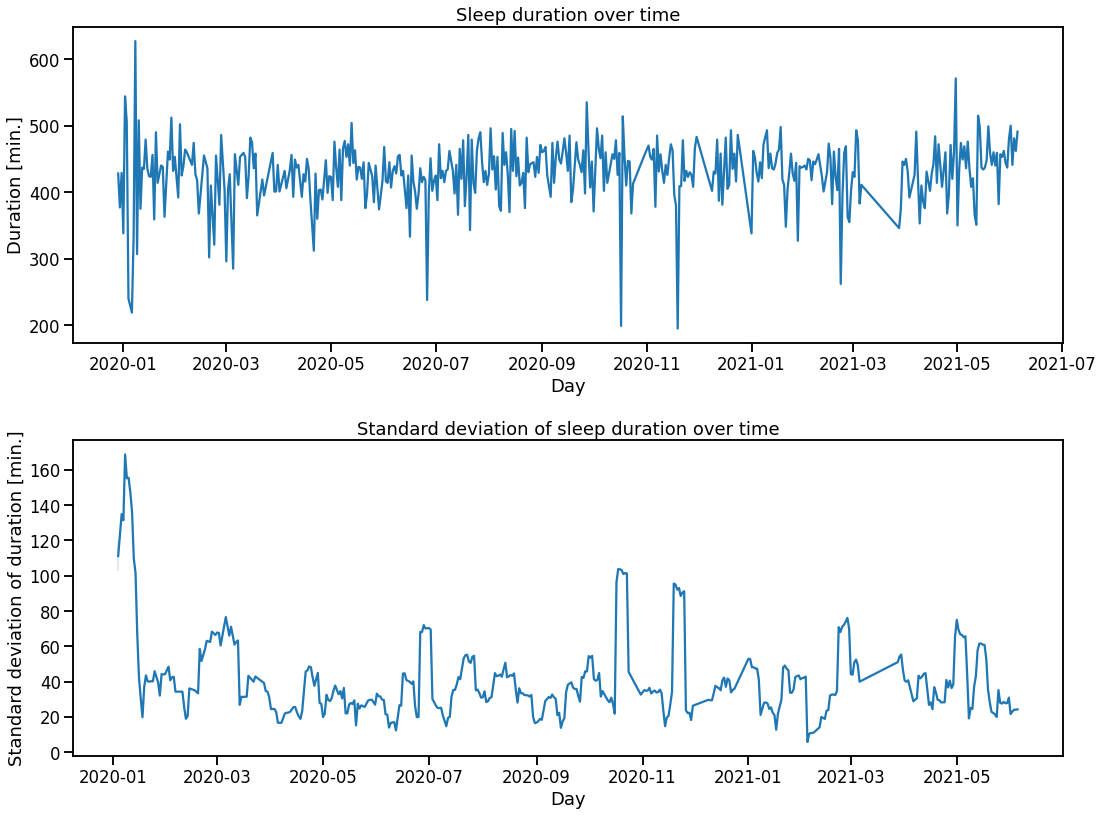

In [11]:
sns.set_context("talk")
FIGSIZE_TS=(15, 7)

df_sleep_merged["minutesAsleep_rolling_std"] = df_sleep_merged["minutesAsleep"].rolling(7).std()

fig, ax = plt.subplots(2, 1, figsize=FIGSIZE_TS)

plt.tight_layout()
plt.subplots_adjust(bottom=-0.5)

sns.lineplot(x="dateOfSleep", y="minutesAsleep", data=df_sleep_merged, ax=ax[0])
ax[0].set_title("Sleep duration over time")
ax[0].set_xlabel("Day")
ax[0].set_ylabel("Duration [min.]")

sns.lineplot(x="dateOfSleep", y="minutesAsleep_rolling_std", data=df_sleep_merged, ax=ax[1])
ax[1].set_title("Standard deviation of sleep duration over time")
ax[1].set_xlabel("Day")
ax[1].set_ylabel("Standard deviation of duration [min.]")

I suspected that there would be variation, but not this much! There were some days where I slept ~3 h, and some where I slept ~10 h. You can see that the standard deviation in sleep duration is fairly variable itself, but it seems to decrease recently, especially towards 2021-06 - 2021-07. This is when I read "How we sleep" and started changing my sleeping habits. It seems that I have become more consistent in my sleep duration recently - great!

### Awake duration

How does my time awake look like over time?

Text(92.25, 0.5, 'Standard deviation of duration [min.]')

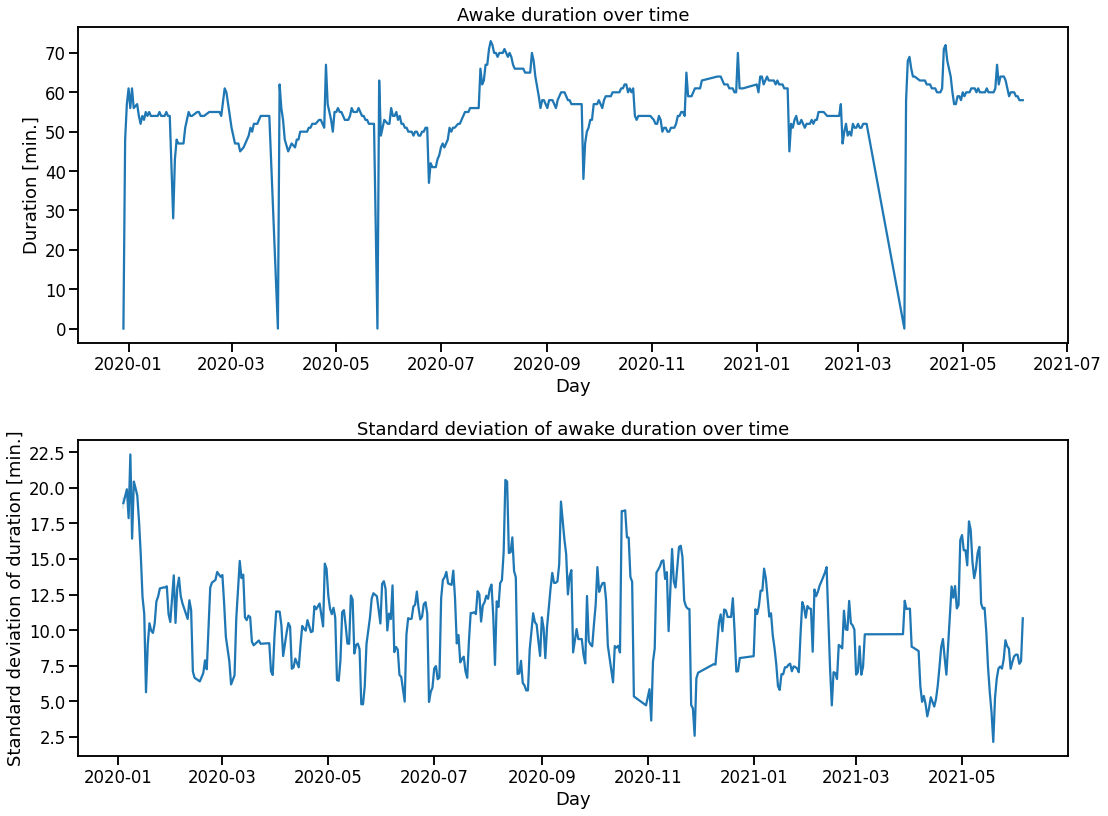

In [12]:
df_sleep_merged["minutesAwake_rolling_std"] = df_sleep_merged["minutesAwake"].rolling(7).std()

fig, ax = plt.subplots(2, 1, figsize=FIGSIZE_TS)

plt.tight_layout()
plt.subplots_adjust(bottom=-0.5)

sns.lineplot(x="dateOfSleep", y="wakeThirtyDayAvgMinutes", data=df_sleep_merged, ax=ax[0])
ax[0].set_title("Awake duration over time")
ax[0].set_xlabel("Day")
ax[0].set_ylabel("Duration [min.]")

sns.lineplot(x="dateOfSleep", y="minutesAwake_rolling_std", data=df_sleep_merged, ax=ax[1])
ax[1].set_title("Standard deviation of awake duration over time")
ax[1].set_xlabel("Day")
ax[1].set_ylabel("Standard deviation of duration [min.]")

The average awake time seems to be ~ 55 mins. Interestingly, it also seems to have decreased in variability towards 2021-05 - 2021-07, which is most likely linked to my changed sleeping habits such as keeping my room dark after 10pm, not using electronic devices 1h before sleep, not drinking water too late, lowering room temperature, etc.

However, the time awake itself has not changed much over time. Perhaps it's too early to draw conclusions from my habit change?

### Deep sleep

I know that I have trouble generating deep sleep - every morning I look with a bit of anxiety at my sleep report to see if I got enough deep sleep. Even before checking it - I can tell if I got enough of it or not by checking how "refreshed" I feel after waking up. This is only anecdotal so far, but I *have* felt that after nights with little deep sleep, I feel "weak" during the day.

Text(92.25, 0.5, 'Standard deviation of duration [min.]')

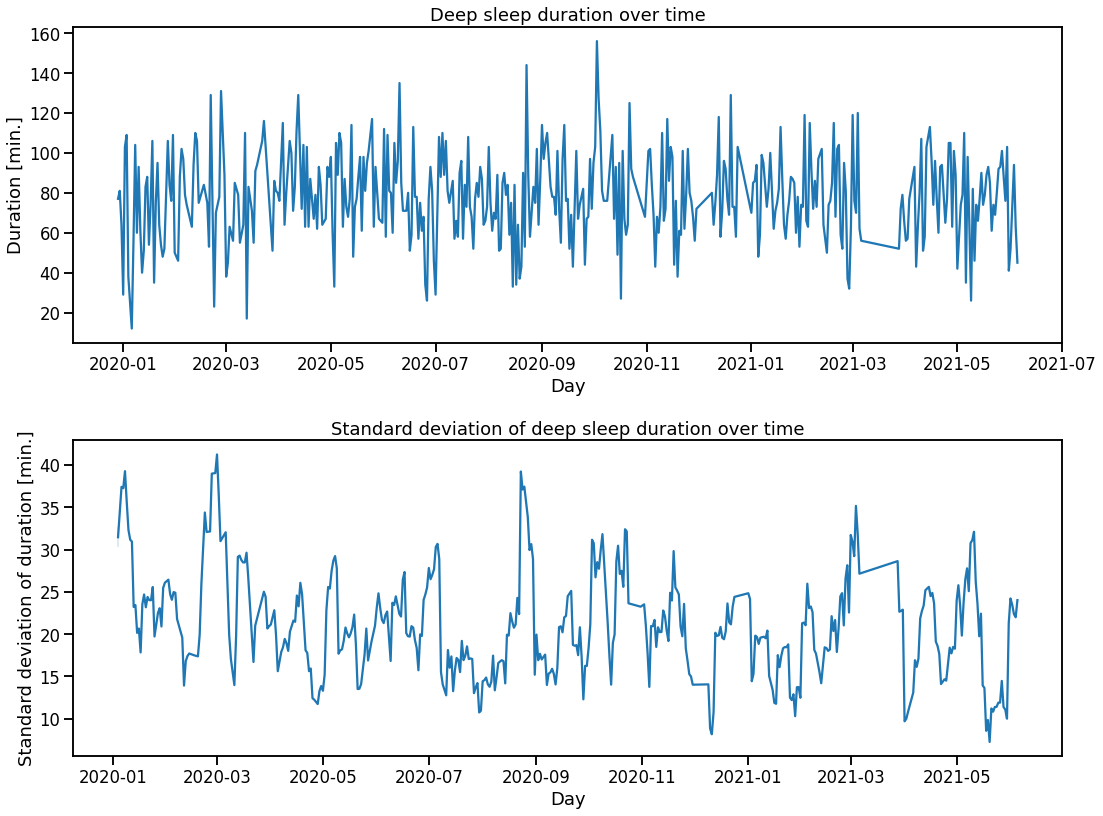

In [13]:
df_sleep_merged["deepMinutes_rolling_std"] = df_sleep_merged["deepMinutes"].rolling(7).std()

fig, ax = plt.subplots(2, 1, figsize=FIGSIZE_TS)

plt.tight_layout()
plt.subplots_adjust(bottom=-0.5)

sns.lineplot(x="dateOfSleep", y="deepMinutes", data=df_sleep_merged, ax=ax[0])
ax[0].set_title("Deep sleep duration over time")
ax[0].set_xlabel("Day")
ax[0].set_ylabel("Duration [min.]")

sns.lineplot(x="dateOfSleep", y="deepMinutes_rolling_std", data=df_sleep_merged, ax=ax[1])
ax[1].set_title("Standard deviation of deep sleep duration over time")
ax[1].set_xlabel("Day")
ax[1].set_ylabel("Standard deviation of duration [min.]")

In [14]:
df_sleep_merged.deepMinutes.mean()

78.0

The duration of my deep sleep seems to have a shape of an inverse parabola. There is also a fair amount of variability in its duration. This agrees fairly well with my observations. One night I feel very refreshed, and the next night I feel horrible during the day, which is typically correlated with my having gotten little deep sleep.


The average duraiton of my deep sleep indicates that I fall within the acceptable range of duration for my age. So - no need to be concerned for now.

### REM sleep

I have been seeing lots of insufficient REM sleep in my sleep reports lately, which got me thinking - do I get less REM sleep than the average 26-year-old?

Text(65.25, 0.5, 'Duration [min.]')

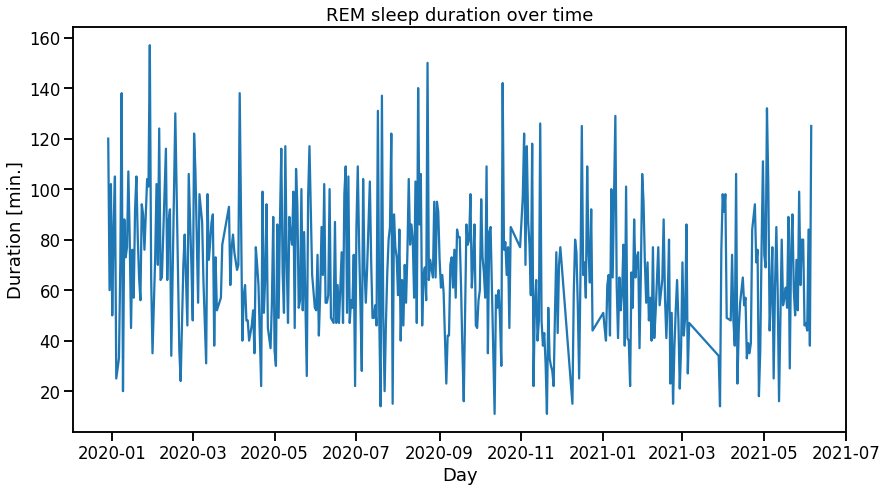

In [15]:
df_sleep_merged["remMinutes_rolling_std"] = df_sleep_merged["remMinutes"].rolling(7).std()

fig, ax = plt.subplots(1, 1, figsize=(12,4))

plt.tight_layout()
plt.subplots_adjust(bottom=-0.5)

sns.lineplot(x="dateOfSleep", y="remMinutes", data=df_sleep_merged, ax=ax)
ax.set_title("REM sleep duration over time")
ax.set_xlabel("Day")
ax.set_ylabel("Duration [min.]")

In [16]:
df_sleep_merged.remMinutes.mean()

67.0453514739229

Oddly enough, the duration of my REM sleep has been on a steady decline since I got the Fitbit... and the mean duration of 67 minutes also doesn't look too good. Given that [REM sleep should comprise 20 - 25% of total sleep time in healthy adults](https://healthysleep.med.harvard.edu/healthy/science/what/sleep-patterns-rem-nrem), 67 minutes definitely falls short of even 20%, assuming a sleep time of 8 hours. In fact, it points to me getting ~100/8 = 12.5% of total sleep time as REM.

This explains my lingering feeling that I'm not "much of a dreamer". REM sleep is more than just about dreaming, and with upcoming grad school I better fix it because it will affect how well I learn stuff.

### Sleep score

Since Fitbit automatically calculates a score based on deep and REM sleep quality (called "composition"), we can see if it correlates with the sum of duration for both sleep stages:

In [17]:
pearsonr(df_sleep_merged.composition_score, df_sleep_merged.deepMinutes + df_sleep_merged.remMinutes)

(0.8724985580260456, 1.2487301592013627e-138)

The correlation is indeed strong, with the coefficient being ~0.87. Therefore, to get a good idea about how "refreshing" a sleep was, I can plot this score over time:

Text(65.25, 0.5, 'Score')

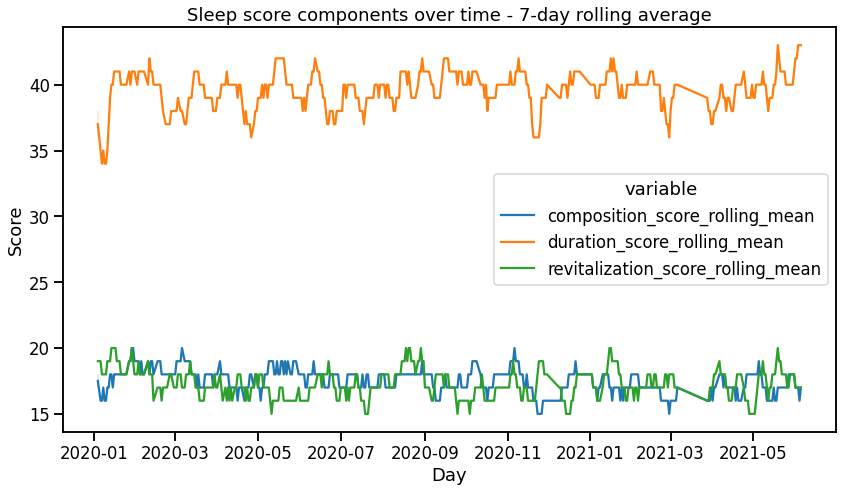

In [18]:
# Melt the df to plot each score component
SET_SCORE_RAW = {"composition_score", "duration_score", "revitalization_score"}
SET_SCORE_ROLLING_MEAN = {"composition_score_rolling_mean", "duration_score_rolling_mean", "revitalization_score_rolling_mean"}

df_sleep_merged["composition_score_rolling_mean"] = df_sleep_merged["composition_score"].rolling(7).mean()
df_sleep_merged["duration_score_rolling_mean"] = df_sleep_merged["duration_score"].rolling(7).mean()
df_sleep_merged["revitalization_score_rolling_mean"] = df_sleep_merged["revitalization_score"].rolling(7).mean()
df_sleep_merged_melt = pd.melt(df_sleep_merged, id_vars="dateOfSleep")
df_sleep_merged_melt = df_sleep_merged_melt[df_sleep_merged_melt["variable"].isin(SET_SCORE_RAW.union(SET_SCORE_ROLLING_MEAN))]
df_sleep_merged_melt = df_sleep_merged_melt.dropna().astype({"variable": "string", "value": "int32"})


fig, ax = plt.subplots(1, 1, figsize=(12,4))

plt.tight_layout()
plt.subplots_adjust(bottom=-0.5)

sns.lineplot(x="dateOfSleep", y="value", hue="variable", 
             data=df_sleep_merged_melt[df_sleep_merged_melt["variable"].isin(SET_SCORE_ROLLING_MEAN)], ax=ax)
ax.set_title("Sleep score components over time - 7-day rolling average")
ax.set_xlabel("Day")
ax.set_ylabel("Score")

The graph above tells us the following story:

- I have been getting better in getting more sleep recently
- My composition score has seen a slight but steady decline ever since I got my Fitbit
- My revitalization score has been fairly constant through time

While controlling my restlessness, % of REM and deep sleep are mostly out of my control, the part of the score I do have control about - duration - seems to be getting better!

### Sleep "efficiency"

[Fitbit calculates sleep efficiency as:](https://community.fitbit.com/t5/Sleep-Well/How-is-sleep-efficiency-calculated/td-p/140651)

$ \frac{time \ asleep}{(total \ time \ in \ bed - time \ to \ fall \ asleep)} $

Therefore, higher scores indicate that when I went to bed, I went *to sleep*, not to just lay around and e.g. play with my phone while staying awake:

Text(65.25, 0.5, 'Efficiency score')

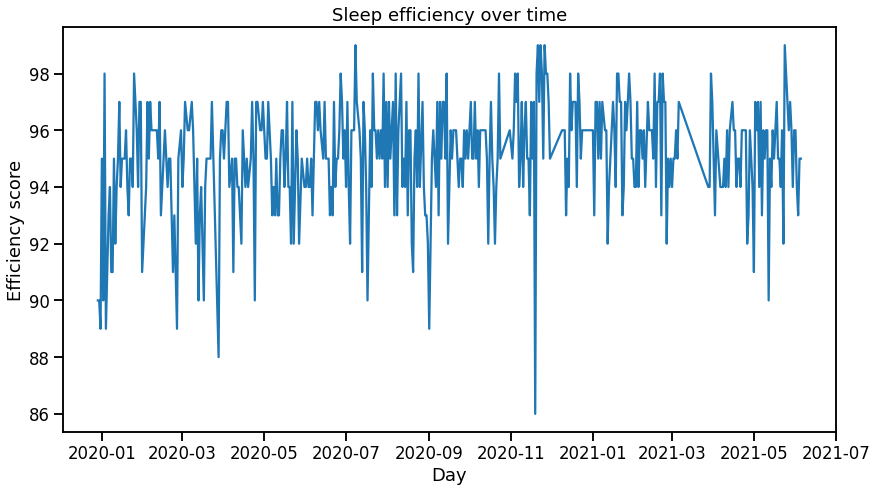

In [19]:
df_sleep_merged["efficiency_rolling_mean"] = df_sleep_merged["efficiency"].rolling(30).mean()

fig, ax = plt.subplots(1, 1, figsize=(12,4))

plt.tight_layout()
plt.subplots_adjust(bottom=-0.5)

sns.lineplot(x="dateOfSleep", y="efficiency", data=df_sleep_merged, ax=ax)
ax.set_title("Sleep efficiency over time")
ax.set_xlabel("Day")
ax.set_ylabel("Efficiency score")

In [20]:
df_sleep_merged.efficiency.mean()

95.08390022675736

For the most part, it seems I'm fairly "efficient", speding > 95% of the time in bed sleeping.

### Sleep quality

#### Per day of week

Lots of people hate Mondays and tend to stress about the upcoming work week, be it incoming dedalines, important meetings, etc. The natural question to ask is: how much does sleep quality vary depending on the day of week?

Text(65.25, 0.5, 'Sleep score (overall)')

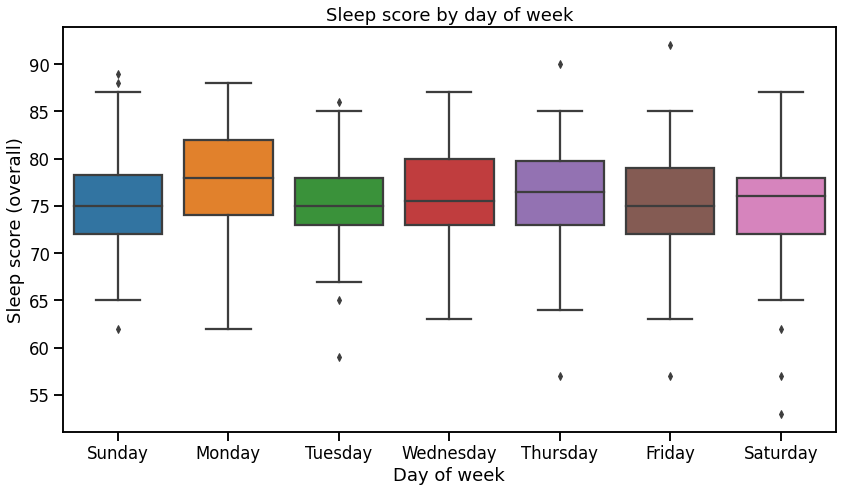

In [21]:
df_sleep_merged["day_of_week"] = df_sleep_merged.dateOfSleep.dt.day_name().astype("string")

fig, ax = plt.subplots(1, 1, figsize=(12,4))

plt.tight_layout()
plt.subplots_adjust(bottom=-0.5)

sns.boxplot(x="day_of_week", y="overall_score", data=df_sleep_merged, ax=ax)
ax.set_title("Sleep score by day of week")
ax.set_xlabel("Day of week")
ax.set_ylabel("Sleep score (overall)")

While there certainly is *some* variation, it's not extremely pronounced. The most interesting points are:

- I seem to be getting the worst sleep on Tuesdays, on average
- I typically get best sleep on... Mondays? (now that's rather... unexpected, to say the least)

What's the weirdest about it all is that I tend to have the worst sleep during the night right after having the best sleep... some kind of regression to the mean?

How about individual score components?

In [22]:
df_sleep_merged_melt["day_of_week"] = df_sleep_merged_melt.dateOfSleep.dt.day_name().astype("string")

Text(65.25, 0.5, 'Sleep score (component value)')

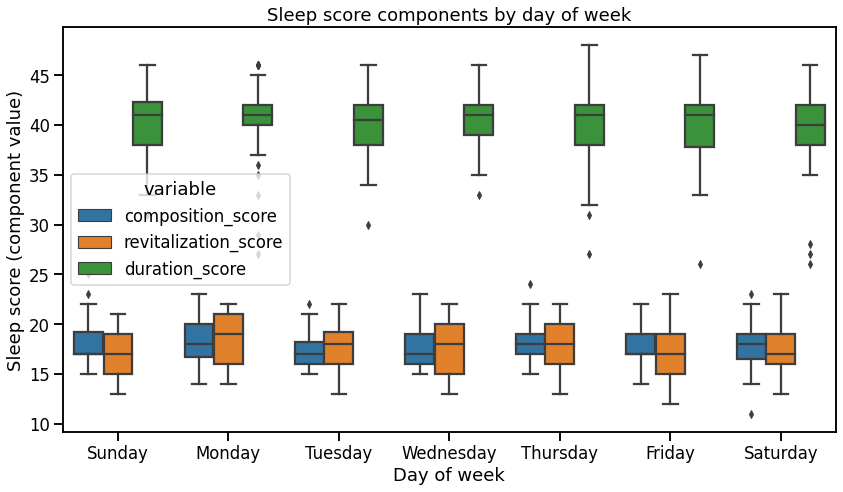

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

plt.tight_layout()
plt.subplots_adjust(bottom=-0.5)

sns.boxplot(x="day_of_week", y="value", hue="variable",
            data=df_sleep_merged_melt[df_sleep_merged_melt["variable"].isin(SET_SCORE_RAW.union({"day_of_week"}))], 
            ax=ax)
ax.set_title("Sleep score components by day of week")
ax.set_xlabel("Day of week")
ax.set_ylabel("Sleep score (component value)")

My duration score is rock-solid, regardless of the day of week (maybe apart from Saturday). The low score in Tuesdays seem to come from a low composition and revitalization score. This means that we should look closer at the duration of deep and REM sleep:

In [24]:
# Calculate % of time spent in each sleep stage
df_sleep_merged["deepPct"] = df_sleep_merged["deepMinutes"] / df_sleep_merged["minutesAsleep"]
df_sleep_merged["lightPct"] = df_sleep_merged["lightMinutes"] / df_sleep_merged["minutesAsleep"]
df_sleep_merged["remPct"] = df_sleep_merged["remMinutes"] / df_sleep_merged["minutesAsleep"]
df_sleep_merged["wakePct"] = df_sleep_merged["wakeMinutes"] / df_sleep_merged["minutesAsleep"]

df_sleep_merged_melt_minutes = df_sleep_merged.melt(id_vars=["dateOfSleep"], value_vars=["deepPct", "remPct", "lightPct", "wakePct"])
df_sleep_merged_melt_minutes["day_of_week"] = df_sleep_merged_melt_minutes["dateOfSleep"].dt.day_name().astype("string")

Text(65.25, 0.5, '% spent in sleep stage')

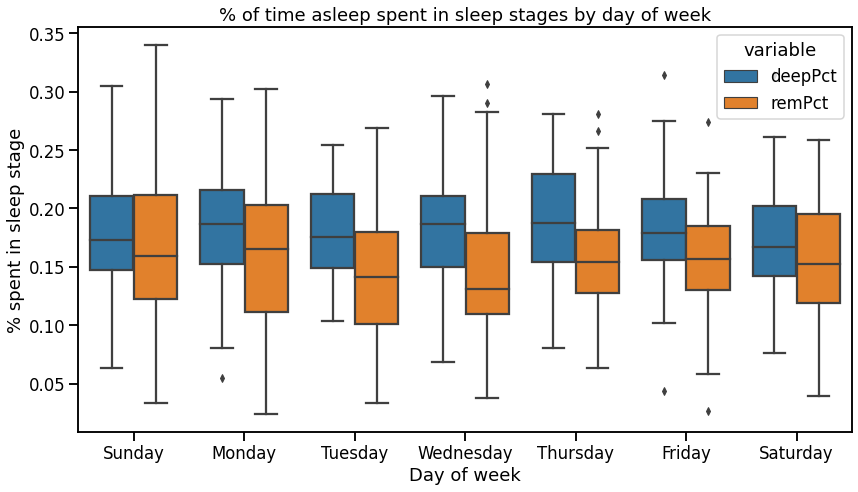

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

plt.tight_layout()
plt.subplots_adjust(bottom=-0.5)

sns.boxplot(x="day_of_week", y="value", hue="variable",
            data=df_sleep_merged_melt_minutes[df_sleep_merged_melt_minutes["variable"].isin(["deepPct", "remPct"])], 
            ax=ax)
ax.set_title("% of time asleep spent in sleep stages by day of week")
ax.set_xlabel("Day of week")
ax.set_ylabel("% spent in sleep stage")

Looking at % of time spent in each sleep stage (to account for any differences in absolute sleep time on different days), it's clear that Tuesdays are the day I get almost the least % of REM sleep (Wednesdays are the worst). % of deep sleep is also lower than most days of week on Tuesdays. I don't have a good explanation for this. It might also just be random noise.

#### As a function of going to sleep on time

One of the important contributors to getting a good night's sleep is being consistent in going to bed at the same time. Let's see if this is reflected in my sleep data:

In [26]:
# Add information about sleep start time
column_sleep_start = []
for row in df_sleep_merged.iterrows():
    column_sleep_start.append(row[1].timestamp - pd.Timedelta(minutes=row[1].timeInBed))
df_sleep_merged["sleepStart"] = column_sleep_start

# Classify each row as "on time" or "not on time" depending on whether I went to sleep before 23:30
def is_sleep_on_time(hour: int, minute: int, timestamp: pd.Timestamp) -> bool:
    # Returns true if I went to sleep before the given hour, False otherwise
    time = timestamp.time()
    date = timestamp.date()
    
    # Should I have gone to sleep the previous day?
    time_desired = datetime.time(hour=hour, minute=minute, second=0)
    
    if time.hour >= 0 and time.hour <= 8:
        date_desired = date - datetime.timedelta(days=1)
    else:
        date_desired = date
        
    datetime_desired = datetime.datetime.combine(date_desired, time_desired)
    
    if timestamp < datetime_desired:
        return True
    
    return False

df_sleep_merged["wasSleepOnTime"] = df_sleep_merged["sleepStart"].apply(lambda x: is_sleep_on_time(hour=23, minute=30, timestamp=x))

Text(29.25, 0.5, 'Overall sleep score')

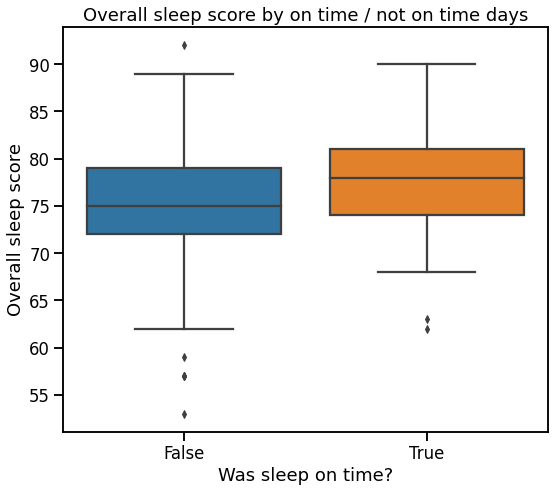

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

plt.tight_layout()
plt.subplots_adjust(bottom=-0.5)

sns.boxplot(x="wasSleepOnTime", y="overall_score", data=df_sleep_merged, ax=ax)
ax.set_title("Overall sleep score by on time / not on time days")
ax.set_xlabel("Was sleep on time?")
ax.set_ylabel("Overall sleep score")

The difference seems to be there, but is it of any significance? Let's see if we can apply a z-test or a t-test.

A crucial assumption behind these tests is that the samples are independent. This doesn't hold, since each night of sleep is might be dependent of the previous night, e.g. if I slept poorly the previous night, I might "make up" the lost sleep the next night.

Another assumption is that the distributions are assumed to be normal. Let's check if that's the case using two normality tests: Shapiro-Wilk and D'Agostino-Pearson:

In [28]:
# D'Agostino-Pearson
print("on time: ", normaltest(df_sleep_merged.overall_score[df_sleep_merged["wasSleepOnTime"] == True]))
print("not on time: ", normaltest(df_sleep_merged.overall_score[df_sleep_merged["wasSleepOnTime"] == False]))

on time:  NormaltestResult(statistic=3.268186441973114, pvalue=0.19512923019194522)
not on time:  NormaltestResult(statistic=24.026392162574204, pvalue=6.06366544826516e-06)


In [29]:
# Shapiro-Wilk
print("on time: ", shapiro(df_sleep_merged.overall_score[df_sleep_merged["wasSleepOnTime"] == True]))
print("not on time: ", shapiro(df_sleep_merged.overall_score[df_sleep_merged["wasSleepOnTime"] == False]))

on time:  ShapiroResult(statistic=0.9788066148757935, pvalue=0.2487260401248932)
not on time:  ShapiroResult(statistic=0.9796591401100159, pvalue=4.803971023648046e-05)


Clearly, the distribution for "on time" scores looks far from normal, in which case we need to use a non-parametric test. We will use the Mann-Whitney U test, as it doesn't make assumptions about the underlying distributions, as opposed to a z-test or a t-test:

In [30]:
scores_ontime = df_sleep_merged["overall_score"][df_sleep_merged["wasSleepOnTime"] == True]
scores_notontime = df_sleep_merged["overall_score"][df_sleep_merged["wasSleepOnTime"] == False]
mannwhitneyu(scores_ontime, scores_notontime, alternative="two-sided")

MannwhitneyuResult(statistic=17338.5, pvalue=0.00016601295258497484)

The p-value is much lower than 0.05, which means that we can reject the null hypothesis that the samples come from the same population. In other words, my sleep scores are indeed better on the days I went to sleep on time!

### Resting heart rate

How does my resting heart rate look like over time?

Text(65.25, 0.5, 'Heart rate [bpm]')

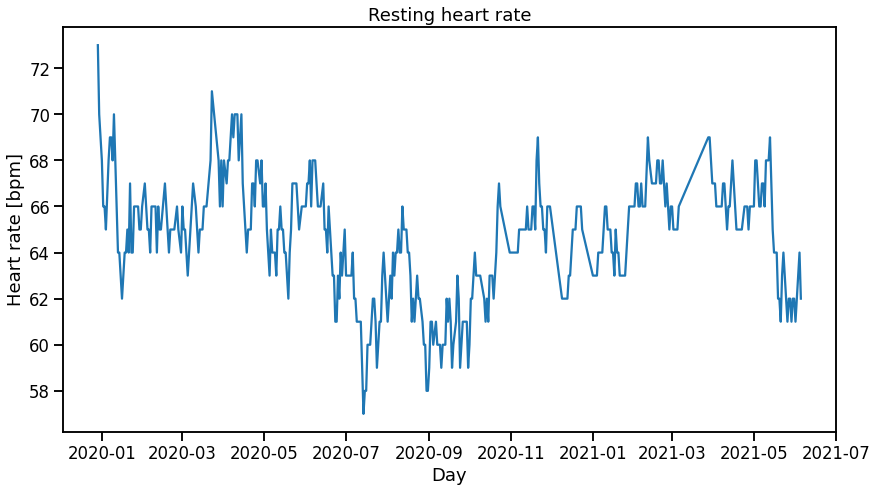

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

plt.tight_layout()
plt.subplots_adjust(bottom=-0.5)

sns.lineplot(x="dateOfSleep", y="resting_heart_rate", data=df_sleep_merged, ax=ax)
ax.set_title("Resting heart rate")
ax.set_xlabel("Day")
ax.set_ylabel("Heart rate [bpm]")

So this graph looks really interesting. First, it shows a really wide range for BPM; from ~58 up to ~73. This is almost like going from fairly fit to a couch potato (just kidding, but "of average cardio fitness" would be an appropriate description).

Secondly, it correlates very well with my periods of more intense exercise - aroud July - August 2020 and recently, after picking up running again.

Finally, it shows very well the impact of lack of cardio exercise - just look at the climb since September 2020 to May 2021. I hadn't ran a single time during that timeframe, and the graph just kept going up. Quite telling.

### Duration of different sleep stage episodes

Fitbit also provides data on the count of e.g. deep sleep episodes. Together with the total duration, we can easily calculate the average time per each episode:

Text(65.25, 0.5, 'Duration [min.]')

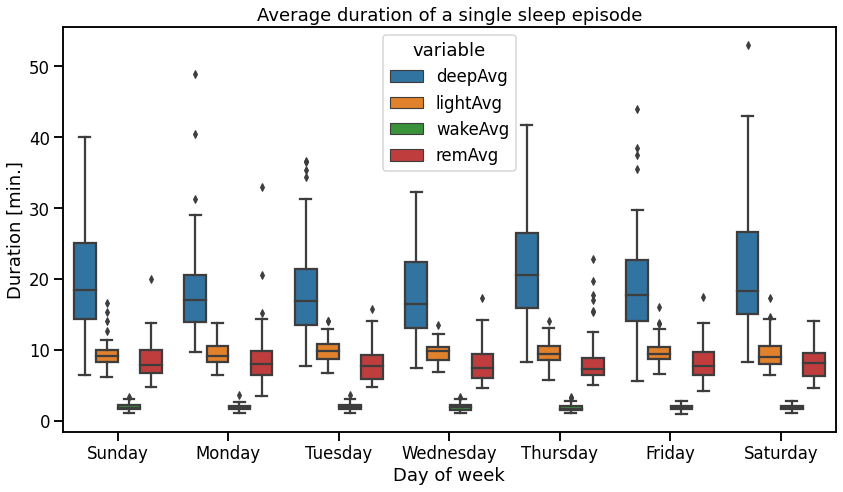

In [32]:
for var_name in ["deep", "light", "wake", "rem"]:
    df_sleep_merged[var_name + "Avg"] = df_sleep_merged[var_name + "Minutes"] / df_sleep_merged[var_name + "Count"]
    df_sleep_merged[var_name + "Avg_rolling_mean"] = df_sleep_merged[var_name + "Avg"].rolling(7).mean()
    
df_sleep_merged_melt_avg = df_sleep_merged.melt(id_vars=["dateOfSleep"], 
                                                value_vars=
                                                ["deepAvg", "lightAvg", "wakeAvg", "remAvg",
                                               "deepAvg_rolling_mean", "lightAvg_rolling_mean", 
                                                 "wakeAvg_rolling_mean", "remAvg_rolling_mean"])
df_sleep_merged_melt_avg = df_sleep_merged_melt_avg.dropna().astype({"variable": "string", "value": "float64"})
df_sleep_merged_melt_avg["day_of_week"] = df_sleep_merged_melt_avg.dateOfSleep.dt.day_name().astype("string")

fig, ax = plt.subplots(1, 1, figsize=(12,4))

plt.tight_layout()
plt.subplots_adjust(bottom=-0.5)

sns.boxplot(x="day_of_week", y="value", hue="variable",
            data=df_sleep_merged_melt_avg[df_sleep_merged_melt_avg["variable"].
                                          isin(["deepAvg", "lightAvg", "wakeAvg", "remAvg"])], 
            ax=ax)
ax.set_title("Average duration of a single sleep episode")
ax.set_xlabel("Day of week")
ax.set_ylabel("Duration [min.]")

A couple of things surface from this graph:

- The average time of a wake episode stays constant across the week
- There is slight variation in the average time of a single REM and light sleep episode
- The most noticeable differences occur in the duration of deep sleep episodes

It seems that a single deep sleep episode is the longest on Thursdays, and the shortest on Wednesdays. Again - I have no idea whatsoever why that would be. But then again - if we look at the change in average values for deep sleep, they are proportionately small, as each deep sleep episode lasts much longer than episode of any other type of sleep. Therefore, it's quite likely that these differences are just noise, and I'm spotting some random patterns.

How does this look over time?

Text(65.25, 0.5, 'Duration [min.]')

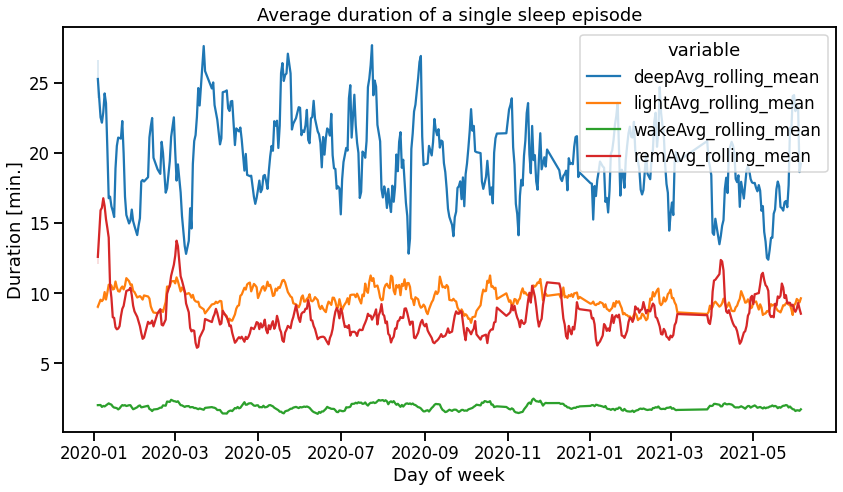

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

plt.tight_layout()
plt.subplots_adjust(bottom=-0.5)

sns.lineplot(x="dateOfSleep", y="value", hue="variable",
            data=df_sleep_merged_melt_avg[df_sleep_merged_melt_avg["variable"].
                                          isin(["deepAvg_rolling_mean", "lightAvg_rolling_mean",
                                               "wakeAvg_rolling_mean", "remAvg_rolling_mean"])], 
            ax=ax)
ax.set_title("Average duration of a single sleep episode")
ax.set_xlabel("Day of week")
ax.set_ylabel("Duration [min.]")

There are very wide variations in the average time of a single deep sleep episode compared to all other sleep types. This again agrees with my observations - I'm often surprised how I get lots of deep sleep one night, and very little the very next night.

### Time spent in sleep stages by time of night

It's well-known that e.g. REM sleep occurs mostly in the "latter" part of the night - i.e. before we wake up. Let's see when each sleep type occurs for me. We will categorize the night into 4 buckets: beginning, early, late, end. This is where our more detailed sleep stage data comes into play.

Let's split the night evenly:

- 23:00 - 01:30 - beginning
- 01:30 - 04:00 - early
- 04:00 - 06:30 - late
- 06:30 - 09:00 - end

In [34]:
def is_time_in_range(time: datetime.time, time_range: Tuple[datetime.time, datetime.time]) -> bool:  
    time_begin = time_range[0]
    time_end = time_range[1]
    
    # Before midnight
    if time_begin < time_end:
        return time >= time_begin and time <= time_end
    # After midnight
    else:
        return time >= time_begin or time <= time_end


def classify_night_stage(timestamp: pd._libs.tslibs.timestamps.Timestamp) -> str:
    range_beginning = datetime.time(23, 0, 0), datetime.time(1, 30, 0)
    range_early = datetime.time(1, 30, 0), datetime.time(4, 0, 0)
    range_late = datetime.time(4, 0, 0), datetime.time(6, 30, 0)
    range_end = datetime.time(6, 30 , 0), datetime.time(9 ,0 , 0)
    
    timestamp = timestamp.time()
    
    if is_time_in_range(timestamp, range_beginning):
        return "beginning"
    elif is_time_in_range(timestamp, range_early):
        return "early"
    elif is_time_in_range(timestamp, range_late):
        return "late"
    elif is_time_in_range(timestamp, range_end):
        return "end"
    else:
        return "out_of_range"

In [35]:
df_sleep_detailed["night_stage"] = df_sleep_detailed.dateTime.apply(lambda x: classify_night_stage(x))
df_sleep_detailed.night_stage.value_counts()

late            3523
early           3092
end             2573
beginning       2235
out_of_range     141
Name: night_stage, dtype: int64

Only 141 records with unclassified timestamps. Let's look at these:

In [36]:
df_sleep_detailed[df_sleep_detailed["night_stage"] == "out_of_range"]

,dateTime,level,seconds,night_stage
0,2020-01-01 22:44:30,light,150,out_of_range
1,2020-01-01 22:47:00,wake,900,out_of_range
35,2020-01-02 09:07:00,light,210,out_of_range
21,2020-01-03 09:05:00,light,690,out_of_range
22,2020-01-03 09:16:30,wake,630,out_of_range
...,...,...,...,...
25,2021-05-02 09:30:00,light,240,out_of_range
26,2021-05-09 09:02:30,deep,420,out_of_range
27,2021-05-09 09:09:30,light,510,out_of_range
28,2021-05-09 09:18:00,rem,540,out_of_range


These are clearly days where I either went to sleep quite early or got up quite late.

### Succession of sleep stages

Is wakefulness *always* followed by light sleep? Or can some REM sleep slip in right after being awake? How about deep sleep - does it only come after light sleep, or can we transition to it from REM sleep too? Let's see!

In [37]:
def generate_ngrams(input_string: str, n: int):
    tokens = input_string.split(" ")
    return ["->".join(tokens[i:i+n]) for i in range(len(tokens)-(n-1))]

def compute_conditional_probability(counter: Counter, state_from: str) -> dict:
    # Get counts for transitions from the given state
    transition_counts_from_state = [(key, value) for (key, value) in counter.items() if key.split("->")[0] == state_from]
    transition_conditional_probabilities = {}
    count_total = sum([elem[1] for elem in transition_counts_from_state])
    
    for transition, count in transition_counts_from_state:
        transition_conditional_probabilities[transition] = count / count_total
    
    return transition_conditional_probabilities

def compute_transition_probabilites_from_counter(counter: Counter) -> dict:
    count_total = sum(counter.values())
    
    transition_probability_dict = {}
    
    states = ["wake", "light", "rem", "deep", "unknown"]
    
    # Probabilities of moving to a different state given the current state
    for transition_type, count in counter.items():
        state_from, state_to = transition_type.split("->")
        prob = count / count_total
        transition_probability_dict[transition_type] = prob
    
    # Probabilities of transitioning from state to itself are 0 by default. Will be overriden later if it's not 0
    for state in states:
        transition_probability_dict[state+"->"+state] = 0
    
    return transition_probability_dict

def make_transition_matrix(counter: Counter, round_digits: int = 4) -> pd.DataFrame:
    # Number of distinct states
    n = 5
    states = ["wake", "light", "rem", "deep", "unknown"]
    
    transition_matrix = pd.DataFrame(columns=states, index=states)
    
    for state_from in states:
        for state_to in states:
            transition_probability_dict = compute_conditional_probability(counter, state_from)
            try:
                transition_matrix.loc[state_from, state_to] = round(transition_probability_dict[state_from+"->"+state_to], round_digits)
            except KeyError:
                transition_matrix.loc[state_from, state_to] = 0.0
    
    return transition_matrix

def get_markov_edges(transition_matrix: pd.DataFrame):
    edges = {}
    for col in transition_matrix.columns:
        for idx in transition_matrix.index:
            edges[(idx,col)] = transition_matrix.loc[idx,col]
    return edges

def compute_percentage_of_states_from(counter: Counter, state_from: str) -> float:
    return 100 * round(sum([v for k, v in counter.items() if k.split("->")[0] == state_from]) / sum(counter.values()), 3)

In [44]:
states = ["wake", "light", "rem", "deep", "unknown"]

sleep_transitions_2 = generate_ngrams(" ".join(list(df_sleep_detailed.level)), 2)
counter_sleep_transitions_2 = Counter(sleep_transitions_2)
transition_matrix = make_transition_matrix(counter_sleep_transitions_2, round_digits=3)
edges_wts = get_markov_edges(transition_matrix)

G = nx.MultiDiGraph()
G.add_nodes_from(states)

for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    # Skip "unknown" state
    if tmp_origin == "unknown" or tmp_destination == "unknown":
        continue
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog="dot")
# nx.draw_networkx(G, pos)

edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
# nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, '../outputs/graph_sleep_transitions.dot')

# Convert .dot to .png
os.system("dot -Tpng ../outputs/graph_sleep_transitions.dot -o ../outputs/graph_sleep_transitions.png")

# Confidence check - probabilities of outgoing edges should sum to 1 for each node
transition_matrix.sum(axis=1)

wake       1.0
light      1.0
rem        1.0
deep       1.0
unknown    1.0
dtype: float64

![](../outputs/graph_sleep_transitions.png)

And here is our stochastic matrix and a graph describing the transition probabilities! We can read off a couple interesting facts from it:

- The most common transition from wakefulness is to light sleep. This makes sense - going from wakefulness to deep or REM sleep is [typically very rare](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2982738/#__sec11title):
> *Transitions between NREM sleep and wake (i.e., NW and WN transitions) were the most common, accounting for approximately 70% of all sleep stage transitions. The least common transition was from wake to REM sleep (WR), with a median rate of 0.21 events/h.*

- The most common transition from light sleep is to REM sleep, followed by to deep and wakefulness. In fact, the light -> REM sleep is the most common transition of all types. What's more is that transition from light sleep to any other stage account for:

In [39]:
compute_percentage_of_states_from(counter_sleep_transitions_2, "light")

46.7

percent of all transitions!

- The `unknown` state is likely due to Fitbit's inability to detect the sleep stage reliably. It only ever transitioned to `wake`

- `wake` and `light` stages seem to transition to themselves occasionally. I can only speculate that's because of Fitbit's limitation, and not an actual transition. Perhaps a given sleep stage was classified as finished while it was still happening, and Fitbit immediately classified the following stage as of the same type?

- It seems that there were some transitions directly from `wake` to `deep` which looks unexpected to me. It might be a genuine transition, or a bogus one due to Fitbit's misclassification of sleep stages